# CDOM-SST Anomaly Difference Analysis: August 2012

This notebook analyzes CDOM and SST Anomaly data for two time periods in August 2012:
- **Period 1**: August 24-28, 2012
- **Period 2**: August 29 - September 2, 2012

**Analysis Steps:**
1. Process CDOM and SST Anomaly data for each time period separately
2. Create combined product maps for each period using matter colormap
3. Calculate the difference between the two periods using balance colormap

**Data Sources:**
- L2 RRS data: `satdata/Texas Louisiana Shelf_2012-08-24_2012-09-02`
- MUR L4 SST Anomaly: `satdata/MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2012-08-24_2012-09-02`

### Library Imports

Import essential libraries for file handling, numerical operations, plotting, and custom processing for both L2 and L3 data.

In [1]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr
import matplotlib.colors
import cmocean
from datetime import datetime

import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.abspath(".."))

# Import custom pipeline components
import importlib
from pipelines import l2_pipeline
importlib.reload(l2_pipeline)
from pipelines.l2_pipeline import L2DatasetLoader, GPUDataExtractor as GPUDataExtractorL2, SelectiveInterpolator as SelectiveInterpolatorL2

from pipelines import l3_pipeline
importlib.reload(l3_pipeline)
from pipelines.l3_pipeline import L3DatasetLoader, GPUDataExtractor as GPUDataExtractorL3, SelectiveInterpolator as SelectiveInterpolatorL3

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

### Define Constants and Parameters

Define constants for CDOM calculation, SST Anomaly processing, geographical area, binning, and data paths for both time periods.

In [2]:
# --- Shared Geographical and Binning Parameters ---
lon_min, lon_max = -95.0, -88.0
lat_min, lat_max = 27.5, 30.5

lat_bins = 200  # Number of latitude bins (height)
lon_bins = 300  # Number of longitude bins (width)

# --- CDOM Calculation Constants ---
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# --- L2 RRS Data Configuration (for CDOM) ---
data_dir_l2_rrs = r"satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02"
rrs_vars_list = ['Rrs_412', 'Rrs_555']
rrs_data_group = 'geophysical_data'
interpolation_threshold_cdom = 32

# --- MUR L4 SST Anomaly Data Configuration ---
data_dir_sst_anom = r"satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2012-08-24_2012-09-02"
sst_anom_variable_to_plot = 'sst_anomaly'
sst_anom_variables_to_load = [sst_anom_variable_to_plot]
min_ssta_threshold = -10.0
max_ssta_threshold = 10.0
interpolation_threshold_sst_anom = 32

# --- Time Period Definitions ---
period1_start = datetime(2012, 8, 24)
period1_end = datetime(2012, 8, 28, 23, 59, 59)
period2_start = datetime(2012, 8, 29)
period2_end = datetime(2012, 9, 2, 23, 59, 59)

print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"Grid: {lat_bins} lat bins, {lon_bins} lon bins")
print(f"Period 1: {period1_start.strftime('%Y-%m-%d')} to {period1_end.strftime('%Y-%m-%d')}")
print(f"Period 2: {period2_start.strftime('%Y-%m-%d')} to {period2_end.strftime('%Y-%m-%d')}")

Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
Grid: 200 lat bins, 300 lon bins
Period 1: 2012-08-24 to 2012-08-28
Period 2: 2012-08-29 to 2012-09-02


### Helper Functions

Define utility functions for data processing, filtering, and normalization.

In [3]:
def filter_files_by_date(nc_files, start_date, end_date):
    """Filter NetCDF files based on date range."""
    filtered_files = []
    for file_path in nc_files:
        filename = os.path.basename(file_path)
        # Extract date from filename - assuming format includes date info
        try:
            # For L2 files, typically have format like AQUA_MODIS.20120824T...
            # For MUR files, typically have format like 20120824090000-JPL-L4_GHRSST...
            if 'AQUA_MODIS' in filename:
                date_str = filename.split('.')[1][:8]  # Extract YYYYMMDD
            elif 'JPL-L4_GHRSST' in filename:
                date_str = filename[:8]  # First 8 characters are YYYYMMDD
            else:
                # Fallback: try to find 8-digit date pattern
                import re
                match = re.search(r'(\d{8})', filename)
                if match:
                    date_str = match.group(1)
                else:
                    continue
            
            file_date = datetime.strptime(date_str, '%Y%m%d')
            if start_date <= file_date <= end_date:
                filtered_files.append(file_path)
        except (ValueError, IndexError):
            # Skip files that don't match expected format
            continue
    
    return filtered_files

def normalize_cdom_custom(data_array, cdom_min=0.01, cdom_max=0.16):
    """Normalizes CDOM data: maps [cdom_min, cdom_max] to [0, 1] and clamps values outside this range."""
    clamped_data = np.clip(data_array, cdom_min, cdom_max)
    normalized_array = (clamped_data - cdom_min) / (cdom_max - cdom_min)
    normalized_array[np.isnan(data_array)] = np.nan
    return normalized_array

def index_sst_anomaly_zero_maps_one(data_array):
    """Indexes SST anomaly so that 0 maps to 1 and the minimum value maps to 0 (clamped to [0,1])."""
    original_nans = np.isnan(data_array)
    valid_values = data_array[~original_nans]
    if valid_values.size == 0:
        return np.full_like(data_array, np.nan)
    min_val = np.nanmin(valid_values)
    # Avoid division by zero if min_val == 0
    if np.isclose(min_val, 0):
        indexed = np.ones_like(data_array)
    else:
        indexed = (data_array - min_val) / (0 - min_val)
    indexed = np.clip(indexed, 0, 1)
    indexed[original_nans] = np.nan
    return indexed

def process_period_data(nc_files_rrs, nc_files_sst, start_date, end_date, period_name):
    """Process CDOM and SST anomaly data for a specific time period."""
    print(f"\n=== Processing {period_name} ===")
    
    # Filter files by date
    period_rrs_files = filter_files_by_date(nc_files_rrs, start_date, end_date)
    period_sst_files = filter_files_by_date(nc_files_sst, start_date, end_date)
    
    print(f"Found {len(period_rrs_files)} L2 RRS files for {period_name}")
    print(f"Found {len(period_sst_files)} SST Anomaly files for {period_name}")
    
    # Initialize outputs
    binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan)
    binned_sst_anom_interpolated = np.full((lat_bins, lon_bins), np.nan)
    lat_edges_grid = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_edges_grid = np.linspace(lon_min, lon_max, lon_bins + 1)
    
    # Process CDOM data
    if period_rrs_files:
        try:
            loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group)
            datasets_rrs = loader_rrs.load_multiple(period_rrs_files)
            print(f"Successfully loaded {len(datasets_rrs)} L2 RRS datasets for {period_name}")
            
            if datasets_rrs:
                extractor_rrs = GPUDataExtractorL2(variables=rrs_vars_list)
                lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
                print(f"L2 RRS data extraction for {period_name} complete. Extracted {len(lon_rrs_flat)} data points.")
                
                # Calculate CDOM
                if lon_rrs_flat.size > 0 and rrs_vars_data_flat:
                    Rss412 = rrs_vars_data_flat.get(rrs_vars_list[0], np.array([]))
                    Rss555 = rrs_vars_data_flat.get(rrs_vars_list[1], np.array([]))
                    
                    if Rss412.size > 0 and Rss555.size > 0:
                        term_ratio = Rss412 / Rss555
                        term_numerator = term_ratio - B0
                        term_division = term_numerator / B2
                        valid_log_mask = term_division > 0
                        
                        cdom_values = np.full_like(term_division, np.nan)
                        if np.any(valid_log_mask):
                            cdom_values[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
                        
                        valid_mask = ~np.isnan(lon_rrs_flat) & ~np.isnan(lat_rrs_flat) & ~np.isnan(cdom_values)
                        final_lon_cdom = lon_rrs_flat[valid_mask]
                        final_lat_cdom = lat_rrs_flat[valid_mask]
                        final_cdom_raw = cdom_values[valid_mask]

                        clip_mask_cdom = (
                            (final_lon_cdom >= lon_min) & (final_lon_cdom <= lon_max) &
                            (final_lat_cdom >= lat_min) & (final_lat_cdom <= lat_max)
                        )
                        clipped_lon_cdom = final_lon_cdom[clip_mask_cdom]
                        clipped_lat_cdom = final_lat_cdom[clip_mask_cdom]
                        clipped_cdom_raw = final_cdom_raw[clip_mask_cdom]
                        print(f"Clipped CDOM data for {period_name}. {len(clipped_lon_cdom)} points remaining.")

                        if clipped_lon_cdom.size > 0:
                            binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, _ = binned_statistic_2d(
                                clipped_lat_cdom, clipped_lon_cdom, clipped_cdom_raw,
                                statistic='mean', bins=[lat_bins, lon_bins], 
                                range=[[lat_min, lat_max], [lon_min, lon_max]]
                            )
                            binned_cdom_interpolated = SelectiveInterpolatorL2.interpolate(
                                binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, threshold=interpolation_threshold_cdom
                            )
                            print(f"CDOM processing for {period_name} complete.")
        except Exception as e:
            print(f"Error during CDOM processing for {period_name}: {e}")
    
    # Process SST Anomaly data
    if period_sst_files:
        try:
            bbox = (lon_min, lon_max, lat_min, lat_max)
            loader_ssta = L3DatasetLoader(variables=sst_anom_variables_to_load, bbox=bbox)
            datasets_ssta = loader_ssta.load_multiple(period_sst_files)
            print(f"Successfully loaded {len(datasets_ssta)} SST Anomaly datasets for {period_name}")
            
            if datasets_ssta:
                extractor_ssta = GPUDataExtractorL3(variables=sst_anom_variables_to_load)
                lon_ssta_flat, lat_ssta_flat, ssta_vars_data_flat = extractor_ssta.extract(datasets_ssta)
                print(f"SST Anomaly data extraction for {period_name} complete. Extracted {len(lon_ssta_flat)} data points.")
                
                if lon_ssta_flat.size > 0 and sst_anom_variable_to_plot in ssta_vars_data_flat:
                    all_ssta = ssta_vars_data_flat[sst_anom_variable_to_plot]
                    
                    all_ssta[(all_ssta < min_ssta_threshold) | (all_ssta > max_ssta_threshold)] = np.nan
                    print(f"SSTA thresholded outside ({min_ssta_threshold}, {max_ssta_threshold})°C for {period_name}.")

                    valid_mask_ssta = ~np.isnan(lon_ssta_flat) & ~np.isnan(lat_ssta_flat) & ~np.isnan(all_ssta)
                    final_lon_ssta = lon_ssta_flat[valid_mask_ssta]
                    final_lat_ssta = lat_ssta_flat[valid_mask_ssta]
                    final_ssta_processed = all_ssta[valid_mask_ssta]

                    if final_lon_ssta.size > 0:
                        binned_ssta_raw_stat, _, _, _ = binned_statistic_2d(
                            final_lat_ssta, final_lon_ssta, final_ssta_processed,
                            statistic='mean', bins=[lat_edges_grid, lon_edges_grid]
                        )
                        
                        binned_sst_anom_interpolated = SelectiveInterpolatorL3.interpolate(
                            binned_ssta_raw_stat, lat_edges_grid, lon_edges_grid, threshold=interpolation_threshold_sst_anom
                        )
                        print(f"SST Anomaly processing for {period_name} complete.")
        except Exception as e:
            print(f"Error during SST Anomaly processing for {period_name}: {e}")
    
    # Create combined product
    cdom_normalized = normalize_cdom_custom(binned_cdom_interpolated)
    sst_anom_indexed = index_sst_anomaly_zero_maps_one(binned_sst_anom_interpolated)
    sst_anom_inverted = 1 - sst_anom_indexed
    combined_product = cdom_normalized * sst_anom_inverted
    
    print(f"Combined product for {period_name} range: {np.nanmin(combined_product):.4f} to {np.nanmax(combined_product):.4f}")
    
    return combined_product, lat_edges_grid, lon_edges_grid

## Data Loading and Processing

### Finding Data Files

In [4]:
# Find all NetCDF files for both datasets
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)
nc_files_sst_anom = glob.glob(os.path.join(data_dir_sst_anom, '**', '*.nc'), recursive=True)

print(f"Found {len(nc_files_rrs)} total L2 RRS files")
print(f"Found {len(nc_files_sst_anom)} total SST Anomaly files")

if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}")
if not nc_files_sst_anom:
    print(f"Warning: No .nc files found for SST Anomaly in {data_dir_sst_anom}")

# Preview some filenames to understand the naming convention
if nc_files_rrs:
    print("\nSample L2 RRS filenames:")
    for i, f in enumerate(nc_files_rrs[:3]):
        print(f"  {os.path.basename(f)}")
    if len(nc_files_rrs) > 3:
        print(f"  ... and {len(nc_files_rrs) - 3} more")

if nc_files_sst_anom:
    print("\nSample SST Anomaly filenames:")
    for i, f in enumerate(nc_files_sst_anom[:3]):
        print(f"  {os.path.basename(f)}")
    if len(nc_files_sst_anom) > 3:
        print(f"  ... and {len(nc_files_sst_anom) - 3} more")

Found 0 total L2 RRS files
Found 0 total SST Anomaly files


### Processing Both Time Periods

Process CDOM and SST Anomaly data for each time period separately.

In [5]:
# Process Period 1: August 24-28, 2012
period1_product, lat_edges_grid, lon_edges_grid = process_period_data(
    nc_files_rrs, nc_files_sst_anom, period1_start, period1_end, "Period 1 (Aug 24-28)"
)

# Process Period 2: August 29 - September 2, 2012
period2_product, _, _ = process_period_data(
    nc_files_rrs, nc_files_sst_anom, period2_start, period2_end, "Period 2 (Aug 29 - Sep 2)"
)

# Calculate the difference between periods
difference_product = period2_product - period1_product

print(f"\nDifference product range: {np.nanmin(difference_product):.4f} to {np.nanmax(difference_product):.4f}")
print(f"Number of valid pixels in Period 1: {np.sum(~np.isnan(period1_product))}")
print(f"Number of valid pixels in Period 2: {np.sum(~np.isnan(period2_product))}")
print(f"Number of valid pixels in Difference: {np.sum(~np.isnan(difference_product))}")


=== Processing Period 1 (Aug 24-28) ===
Found 0 L2 RRS files for Period 1 (Aug 24-28)
Found 0 SST Anomaly files for Period 1 (Aug 24-28)
Combined product for Period 1 (Aug 24-28) range: nan to nan

=== Processing Period 2 (Aug 29 - Sep 2) ===
Found 0 L2 RRS files for Period 2 (Aug 29 - Sep 2)
Found 0 SST Anomaly files for Period 2 (Aug 29 - Sep 2)
Combined product for Period 2 (Aug 29 - Sep 2) range: nan to nan

Difference product range: nan to nan
Number of valid pixels in Period 1: 0
Number of valid pixels in Period 2: 0
Number of valid pixels in Difference: 0


## Visualization

### Period 1: August 24-28, 2012

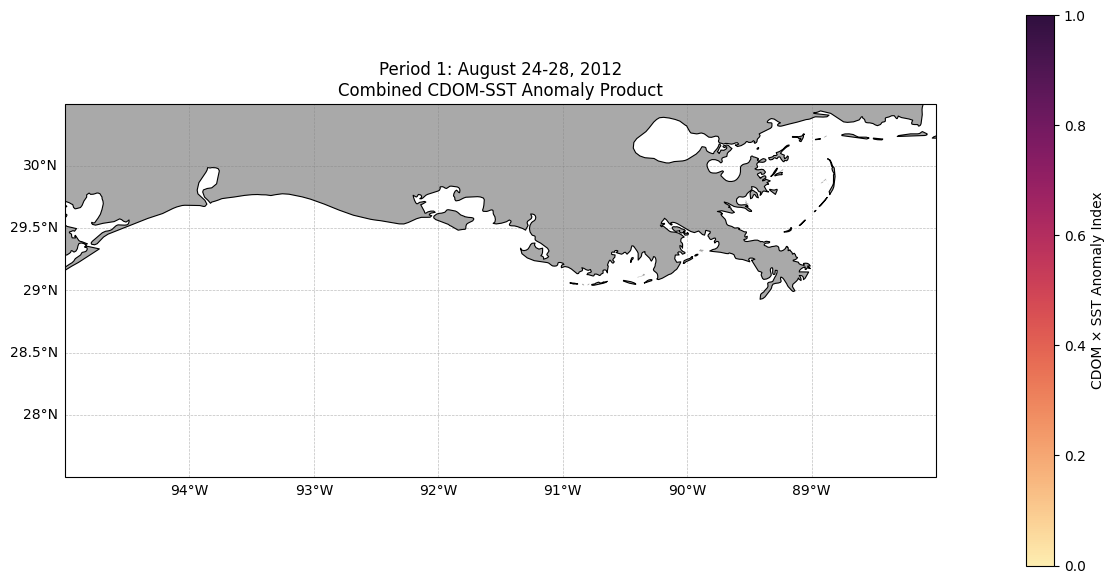

In [6]:
# Plot Period 1 combined product
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())

# Use matter colormap as requested
period1_plot = ax.pcolormesh(lon_edges_grid, lat_edges_grid, period1_product,
                            cmap=cmocean.cm.matter, shading='auto',
                            vmin=0, vmax=1, transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add colorbar
cbar = fig.colorbar(period1_plot, ax=ax, label='CDOM × SST Anomaly Index', shrink=0.7, pad=0.08)

plt.title("Period 1: August 24-28, 2012\nCombined CDOM-SST Anomaly Product", fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

### Period 2: August 29 - September 2, 2012

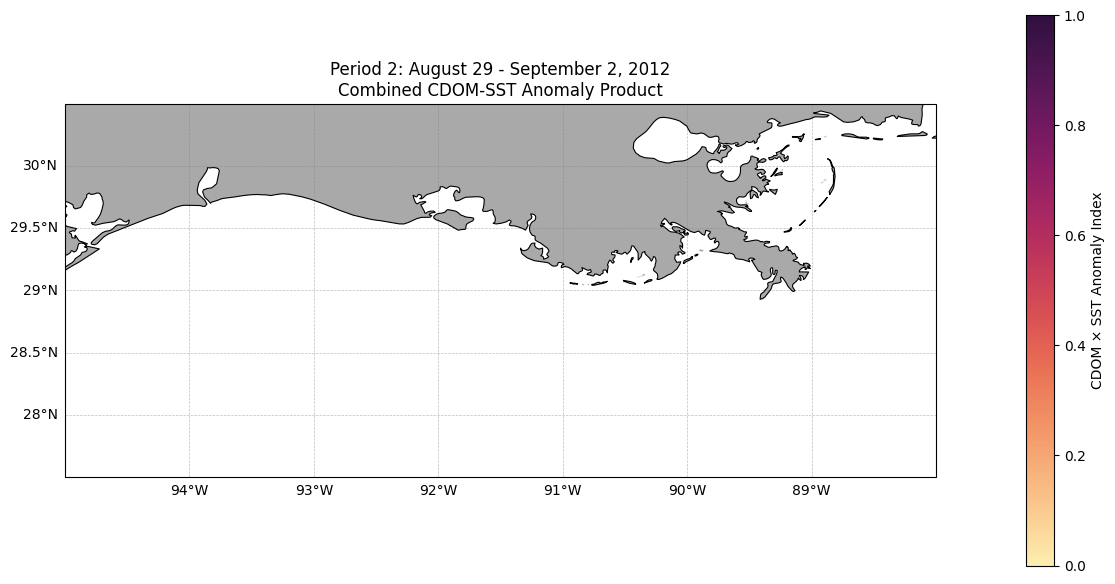

In [7]:
# Plot Period 2 combined product
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())

# Use matter colormap as requested
period2_plot = ax.pcolormesh(lon_edges_grid, lat_edges_grid, period2_product,
                            cmap=cmocean.cm.matter, shading='auto',
                            vmin=0, vmax=1, transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add colorbar
cbar = fig.colorbar(period2_plot, ax=ax, label='CDOM × SST Anomaly Index', shrink=0.7, pad=0.08)

plt.title("Period 2: August 29 - September 2, 2012\nCombined CDOM-SST Anomaly Product", fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

### Difference Map: Period 2 - Period 1

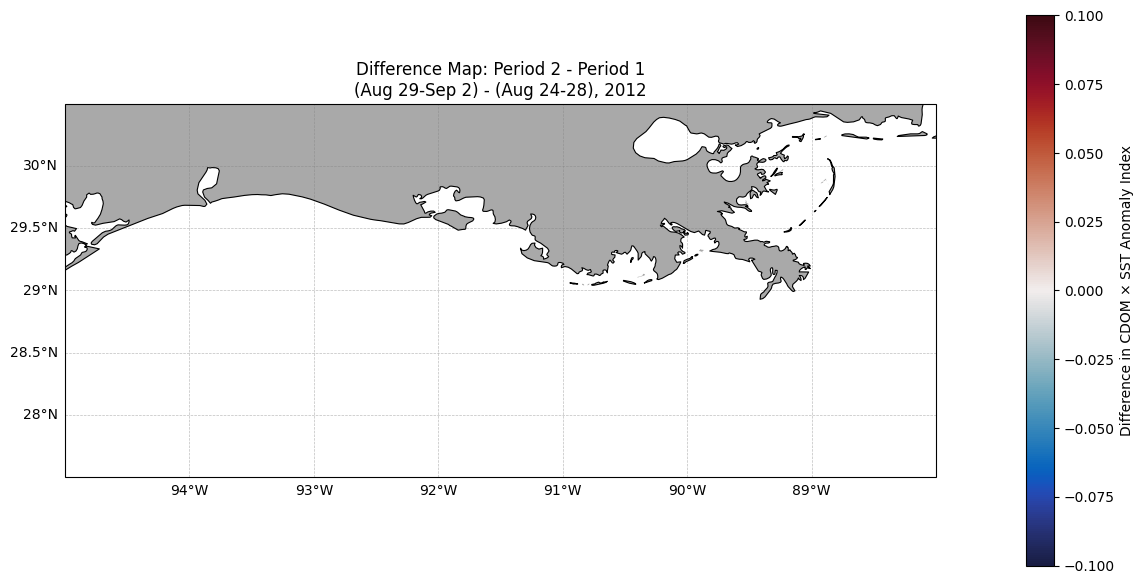

Difference statistics:
  Mean difference: nan
  Std difference: nan
  Min difference: nan
  Max difference: nan
  Range used for plotting: -0.1000 to 0.1000


In [8]:
# Plot the difference map
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())

# Calculate symmetric color limits for the difference
valid_diff = difference_product[~np.isnan(difference_product)]
if len(valid_diff) > 0:
    max_abs_diff = np.percentile(np.abs(valid_diff), 95)  # Use 95th percentile to avoid outliers
    diff_vmin, diff_vmax = -max_abs_diff, max_abs_diff
else:
    diff_vmin, diff_vmax = -0.1, 0.1

# Use balance colormap as requested for the difference
diff_plot = ax.pcolormesh(lon_edges_grid, lat_edges_grid, difference_product,
                         cmap=cmocean.cm.balance, shading='auto',
                         vmin=diff_vmin, vmax=diff_vmax, transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add colorbar
cbar = fig.colorbar(diff_plot, ax=ax, label='Difference in CDOM × SST Anomaly Index', shrink=0.7, pad=0.08)

plt.title("Difference Map: Period 2 - Period 1\n(Aug 29-Sep 2) - (Aug 24-28), 2012", fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

print(f"Difference statistics:")
print(f"  Mean difference: {np.nanmean(difference_product):.4f}")
print(f"  Std difference: {np.nanstd(difference_product):.4f}")
print(f"  Min difference: {np.nanmin(difference_product):.4f}")
print(f"  Max difference: {np.nanmax(difference_product):.4f}")
print(f"  Range used for plotting: {diff_vmin:.4f} to {diff_vmax:.4f}")